## Import Libraries and Load the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/Malnutri.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Dataset/Malnutri.zip
   creating: Dataset/
   creating: Dataset/Nitrogen(N)/
  inflating: Dataset/Nitrogen(N)/untitled-1.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-10.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-100.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-101.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-102.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-103.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-104.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-105.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-106.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-107.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-108.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-109.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-11.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-110.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-111.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-112.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-113.

## Exploring the Dataset

In [ ]:
import pathlib
import os
data_dir = '/content/Dataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
print(os.listdir('/content/Dataset'))

['Nitrogen(N)', 'Potassium(K)', 'Phosphorus(P)']


In [ ]:
classes = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']

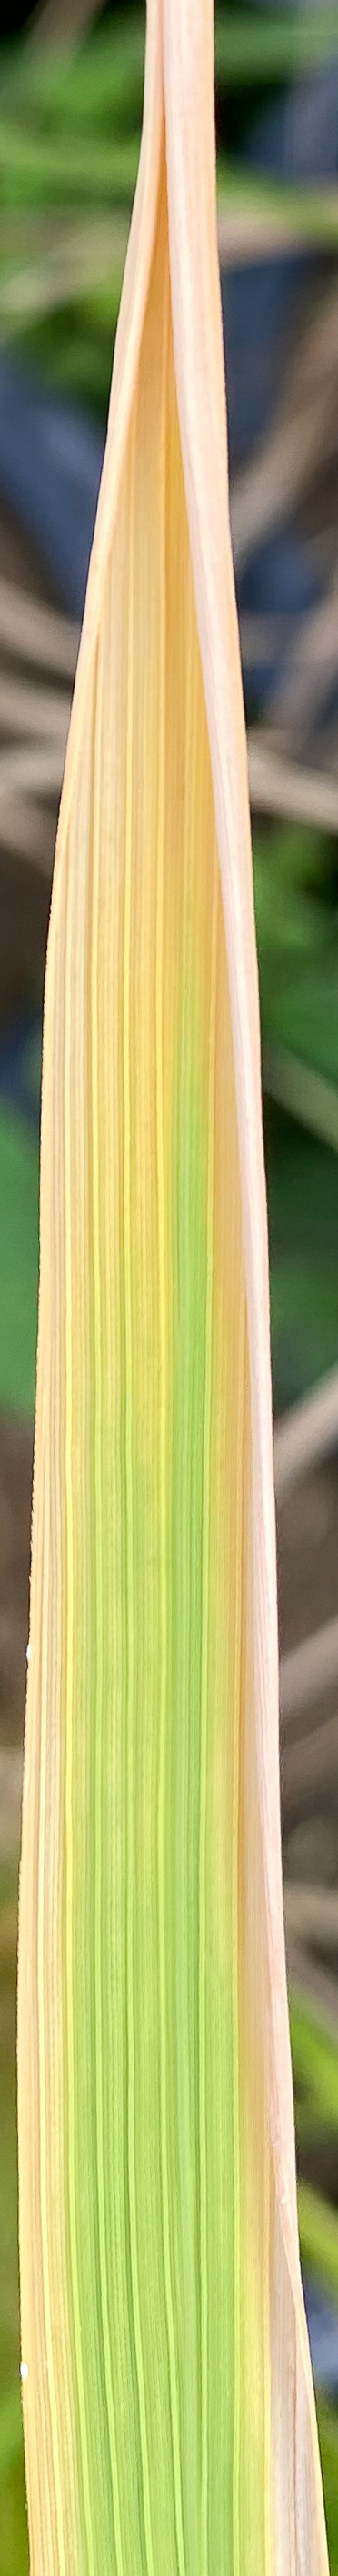

In [ ]:
import PIL
N = list(data_dir.glob('Nitrogen(N)/*'))
PIL.Image.open(str(N[0]))

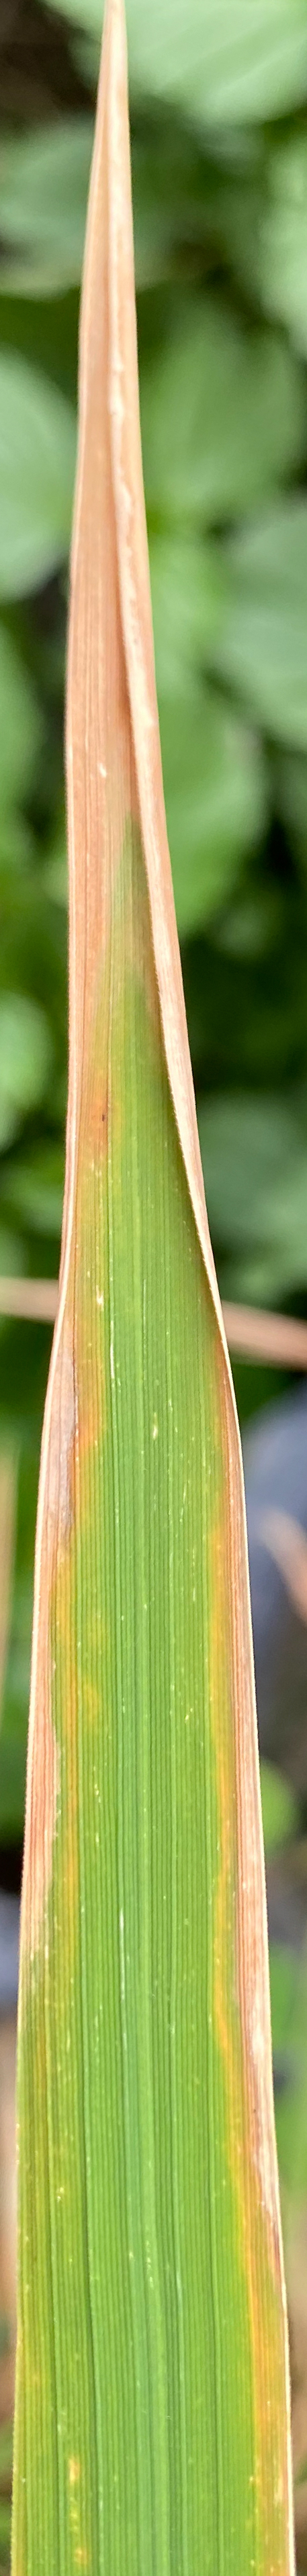

In [ ]:
P = list(data_dir.glob('Phosphorus(P)/*'))
PIL.Image.open(str(P[0]))

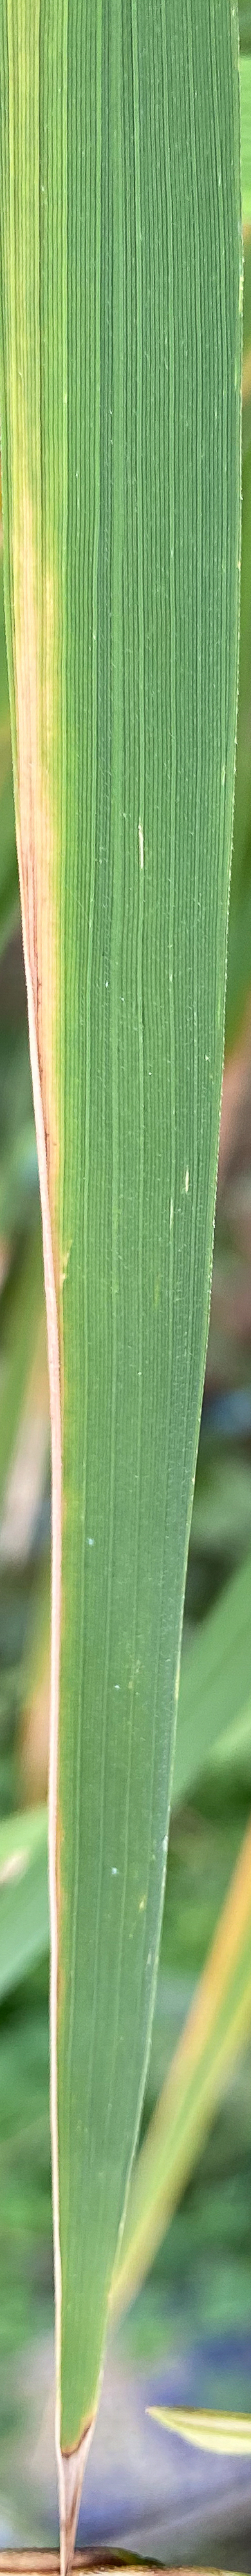

In [ ]:
K = list(data_dir.glob('Potassium(K)/*'))
PIL.Image.open(str(K[0]))

In [ ]:
import cv2
N1 = cv2.imread('/content/Dataset/Nitrogen(N)/untitled-1.JPG')
print(N1.shape)
P1 = cv2.imread('/content/Dataset/Phosphorus(P)/IMG_3784.JPG')
print(P1.shape)
K1 = cv2.imread('/content/Dataset/Potassium(K)/untitled-1.JPG')
print(K1.shape)

(3834, 310, 3)
(3748, 417, 3)
(3796, 471, 3)


## Image Pre-processing

In [ ]:
from pathlib import Path
import cv2

def preprocess(destination_path,target_path):
  format_of_your_images = 'JPG'
  all_the_files = Path(destination_path).rglob(f'*.{format_of_your_images}')
  for f in all_the_files:
    p = cv2.imread(str(f))
    p = cv2.cvtColor(p, cv2.COLOR_BGR2HSV)
    p = cv2.medianBlur(p, 5)
    #  transformation
    cv2.imwrite(f'{target_path}/{f.name}', p)

In [ ]:
destination_path1 = "/content/Dataset/Nitrogen(N)"
target_path1 = "/content/Dataset/Nitrogen(N)"
preprocess(destination_path1, target_path1)

In [ ]:
destination_path2 = "/content/Dataset/Phosphorus(P)"
target_path2 = "/content/Dataset/Phosphorus(P)"
preprocess(destination_path2, target_path2)

In [ ]:
destination_path3 = "/content/Dataset/Potassium(K)"
target_path3 = "/content/Dataset/Potassium(K)"
preprocess(destination_path3, target_path3)

## Data Pre-processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_augment = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  shear_range=0.2,
                                  rotation_range=0,
                                  vertical_flip=True,
                                  horizontal_flip=True,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest',
                                  validation_split=0.2)

In [ ]:
train = data_augment.flow_from_directory(directory=data_dir,
                                         target_size = (256, 256),
                                         batch_size = 64,
                                         class_mode = 'categorical',
                                         shuffle = True,
                                         subset='training')

In [ ]:
valid = data_augment.flow_from_directory(directory = data_dir,
                                         target_size = (256, 256),
                                         batch_size = 64,
                                         class_mode = 'categorical',
                                         shuffle = False,
                                         subset='validation')

## Model Building

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,BatchNormalization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, filters):
        super(Attention, self).__init__()
        self.filters = 64

        self.conv1 = tf.keras.layers.Conv2D(self.filters, kernel_size=3, activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(self.filters, kernel_size=3, activation='sigmoid', padding='same')

    def call(self, inputs):
        # extract features using convolutional layer
        features = self.conv1(inputs)

        # compute attention scores using sigmoid activation
        scores = self.conv2(features)

        # multiply input features with attention scores
        weighted_features = tf.multiply(features, scores)

        # return weighted features
        return weighted_features


In [ ]:
model = Sequential([Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),input_shape=(256,256,3),activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Attention(64), # Attention -->
                    Conv2D(filters=64,kernel_size=(5,5),strides=(2,2),activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(filters=128,kernel_size=(5,5),strides=(2,2),activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    Dropout(0.5),
                    Dense(128,activation='relu'),
                    Dense(3,activation='softmax')])

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(train, epochs=80, validation_data=valid)

Epoch 1/80
13/13 [==============================] - 51s 3s/step - loss: 1.1010 - accuracy: 0.3159 - val_loss: 1.0963 - val_accuracy: 0.3283
Epoch 2/80
13/13 [==============================] - 34s 3s/step - loss: 1.0760 - accuracy: 0.3645 - val_loss: 0.9526 - val_accuracy: 0.5556
Epoch 3/80
13/13 [==============================] - 36s 3s/step - loss: 0.9732 - accuracy: 0.4844 - val_loss: 1.0163 - val_accuracy: 0.4242
Epoch 4/80
13/13 [==============================] - 34s 3s/step - loss: 0.9076 - accuracy: 0.5268 - val_loss: 0.8175 - val_accuracy: 0.5606
Epoch 5/80
13/13 [==============================] - 36s 3s/step - loss: 0.9095 - accuracy: 0.5780 - val_loss: 0.9175 - val_accuracy: 0.5455
Epoch 6/80
13/13 [==============================] - 39s 3s/step - loss: 0.8750 - accuracy: 0.5630 - val_loss: 0.8634 - val_accuracy: 0.5657
Epoch 7/80
13/13 [==============================] - 34s 3s/step - loss: 0.7958 - accuracy: 0.6330 - val_loss: 0.9037 - val_accuracy: 0.5152
Epoch 8/80
13/13 [==

## Evaluation

In [ ]:
loss, accuracy = model.evaluate(valid)

4/4 [==============================] - 7s 1s/step - loss: 0.5158 - accuracy: 0.8131


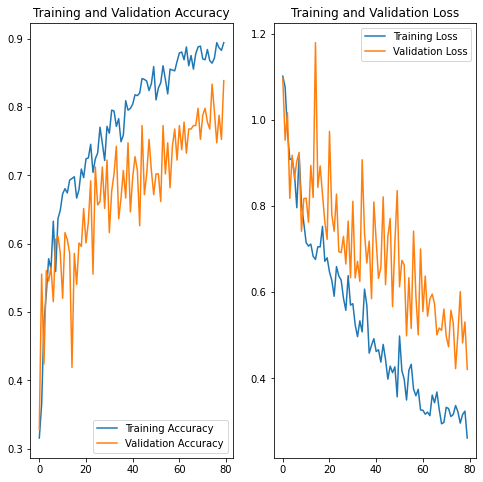

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(80)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Y_pred = model.predict(valid)
y_pred = np.argmax(Y_pred, axis=1)

4/4 [==============================] - 7s 1s/step


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']
print(classification_report(valid.classes, y_pred, target_names=target_names))

               precision    recall  f1-score   support

  Nitrogen(N)       0.98      0.80      0.88        66
Phosphorus(P)       0.75      0.74      0.75        66
 Potassium(K)       0.71      0.85      0.77        66

     accuracy                           0.80       198
    macro avg       0.81      0.80      0.80       198
 weighted avg       0.81      0.80      0.80       198



In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import sklearn.metrics
target_names = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']
print(confusion_matrix(valid.classes, y_pred))#, target_names=target_names))

[[53  7  6]
 [ 0 49 17]
 [ 1  9 56]]


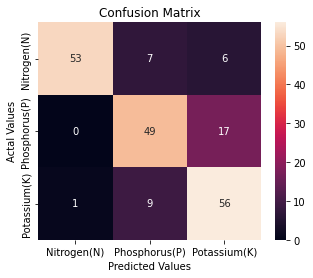

In [ ]:
import seaborn as sns
cm = confusion_matrix(valid.classes, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)'],
                     columns = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Summary


* for 30 epochs, loss: 0.5446 - accuracy: 0.7478

model = Sequential([Conv2D(filters=32,kernel_size=(5,5),padding='same', input_shape=(256,256,3),activation='relu'),  
MaxPooling2D(pool_size=(3,3)),  
Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'),  
MaxPooling2D(pool_size=(2,2)),  
Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),  
MaxPooling2D(pool_size=(2,2)),  
Flatten(),  
Dense(512,activation='relu'),  
Dropout(0.25),  
Dense(128,activation='relu'),  
Dense(3,activation='softmax')])



- for 30 epochs, loss: 0.5529 - accuracy: 0.7522


model = Sequential([Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),input_shape=(256,256,3),activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(filters=64,kernel_size=(5,5),strides=(2,2),activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(filters=128,kernel_size=(5,5),strides=(2,2),activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(0.7),
                    Flatten(),
                    Dense(512,activation='relu'),
                    Dropout(0.7),
                    Dense(128,activation='relu'),
                    Dense(3,activation='softmax')])

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet')
saliency_model = SaliencyMap(model)

img = tf.keras.preprocessing.image.load_img('example.jpg', target_size=(224, 224))
img_arr = tf.keras.preprocessing.image.img_to_array(img)
img_arr = tf.keras.applications.resnet50.preprocess_input(img_arr)

# Get saliency map for input image
saliency_map = saliency_model(tf.constant(img_arr))[0]

# Visualize saliency map overlaid on input image
plt.imshow(img)
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.show()


102967424/102967424 [==============================] - 7s 0us/step


NameError: ignored